<a href="https://colab.research.google.com/github/leoalexandre/mvp_adbp/blob/main/mvp_anp_seismic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MVP de Análise de Dados e Boas Práticas
Por Leonardo da Silva Alexandre

## 1.   Definição do Problema

O dataset utilizado neste projeto foi retirado do site da Agência Nacional do Petróleo (ANP). A criação veio a partir da tabela de atributos retirada do shapefile de todos os programas sísmicos gerados pelo mercado de óleo e gás brasileiro, somado a aplicação de algumas regras presentes na legislação brasileira gerida pela ANP. A legislação nacional pode ser encontrada dentro dos sites da ANP. O shapefile está alocado mais precisamente em:

https://www.gov.br/anp/pt-br/assuntos/exploracao-e-producao-de-oleo-e-gas/dados-tecnicos/acervo-de-dados

O dataset apresenta atributos relacionados aos programas sísmicos com relação a datas, localização, volume, valor, empresas proprietárias dos dados e período de confidencialidade. Seu objetivo é vislumbrar novos processamentos ou aquisições sísmicas com maior potencial de interesse do mercado a partir da identificação de uma ausência de dados de processamento e suas versões em áreas das bacias sedimentares brasileiras que apresentem maior visibilidade da indústria de óleo e gás.
Informações sobre atributos:

  1. **Vol_GB** – Volume da soma dos arquivos do projeto sísmico;
  2. **UDs** – Valor em UD do projeto sísmico;
  3. **Project** – Projeto sísmico oriundo de um programa sísmico;
  4. **Type_Proc** – Tipo de processamento sísmico realizado no programa sísmico;
  5. **Point_Proc** - Pontuação de acordo com o nível do processamento;
  6. **Pub** – Classificação do programa sísmico em público ou confidencial;
  7. **Program** – Programa sísmico criado pela ANP por solicitação da empresa;
  8. **Type_Prog** – Classificação do programa sísmico em Exclusivo (Pré-98), Exclusivo, Não-Exclusivo ou de fomento;
  9. **Dim** – Dimensionalidade do dado sísmico;
  10. **date_start** – Data de início do programa;
  11. **date_end** – Data de término do programa;
  12. **time** - Tempo de existência do programa;
  13. **date_pub** – Data na qual o programa se torna público perante a legislação vigente;
  14. **Bloc** – Bloco exploratório onde está localizado o programa sísmico;
  15. **Field** – Campo de exploração onde está localizado o programa sísmico;
  16. **Basin** – Bacia geológica onde está localizado o programa sísmico;
  17. **Class_Basin** - Pontuação de classificação da bacia por interesse;
  18. **EAD** – Empresa de Aquisição de Dados responsável pelo programa sísmico;
  19. **Operator** – Empresa Operadora detentora dos direitos sobre os dados do programa sísmico.

In [3]:
# Imports
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as ms # para tratamento de missings
from matplotlib import cm
from pandas import set_option
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

In [4]:
# configuração para não exibir os warnings
import warnings
warnings.filterwarnings("ignore")

## 2. Carga de Dados

Para a carga dos dados presentes em um arquivo de extensão csv será utilizado o pacote Pandas (Python Data Analysis Library). O arquivo se encontra armazenado na pasta pública no GitHub e será carregado diretamente do local. Um novo cabeçalho será inserido acompanhando a descrição prévia dos atributos. Após o carregamento do dataset realizado, os dados serão expostos para uma análise inicial.

In [5]:
# Carrega arquivo csv usando Pandas usando uma URL

# Informa a URL de importação do dataset
url = "https://raw.githubusercontent.com/leoalexandre/mvp_adbp/main/dados_anp.csv"

# Informa o cabeçalho das colunas
colunas = ['Vol_GB', 'UDs', 'Project', 'Type_Proc', 'Point_Proc', 'Pub', 'Program', 'Type_Prog', 'Dim', 'date_start','date_end', 'time', 'date_pub', 'Bloc', 'Field', 'Basin', 'Class_Basin', 'EAD', 'Operator']

# Lê o arquivo utilizando as colunas informadas
dataset = pd.read_csv(url, names=colunas, skiprows=1, delimiter=',')


In [6]:
dataset.head()

,Vol_GB,UDs,Project,Type_Proc,Point_Proc,Pub,Program,Type_Prog,Dim,date_start,date_end,time,date_pub,Bloc,Field,Basin,Class_Basin,EAD,Operator
0,0.016620,1.000000,0007_SERGIPE_ALAGOAS_39,STK FIN,0.50,Publico,0007_SERGIPE_ALAGOAS_39,Exclusivo Pre-98,Sismica 2D,08/05/1970,23/08/1970,53,,,,multiplas,6.0,Petrobras,Petrobras
1,NaN,NaN,0007_SERGIPE_ALAGOAS_39,Field Data,0.00,Publico,0007_SERGIPE_ALAGOAS_39,Exclusivo Pre-98,Sismica 2D,08/05/1970,23/08/1970,53,,,,multiplas,6.0,Petrobras,Petrobras
2,18.291451,3.658290,0022_BRASILSPAN01_PSDM,MIG PSDM,2.75,Confidencial,0022_BRASILSPAN01,Nao-Exclusivo,Sismica 2D,17/05/2007,21/06/2008,15,21/06/2026,,,multiplas,6.0,GX Technology,NaN
3,14.677270,2.935454,0022_BRASILSPAN01_PSTM,MIG PSTM,1.50,Confidencial,0022_BRASILSPAN01,Nao-Exclusivo,Sismica 2D,17/05/2007,21/06/2008,15,21/06/2026,,,multiplas,6.0,GX Technology,NaN
4,4283.437811,42.834378,0022_BRASILSPAN01,Field Data,0.00,Confidencial,0022_BRASILSPAN01,Nao-Exclusivo,Sismica 2D,17/05/2007,21/06/2008,15,21/06/2026,,,multiplas,6.0,GX Technology,NaN


## 3. Análise dos Dados

### 3.1 Estatísticas Descritivas

Vamos iniciar examinando as dimensões do dataset, suas informações e alguns exemplos de linhas. MUDAR

In [8]:
# Mostra as dimensões do dataset
print(dataset.shape)

(5783, 19)


In [7]:
# Mostra as informações do dataset
print(dataset.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5783 entries, 0 to 5782
Data columns (total 19 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Vol_GB       4643 non-null   float64
 1   UDs          4643 non-null   float64
 2   Project      5783 non-null   object 
 3   Type_Proc    5783 non-null   object 
 4   Point_Proc   5620 non-null   float64
 5   Pub          5783 non-null   object 
 6   Program      5783 non-null   object 
 7   Type_Prog    5783 non-null   object 
 8   Dim          5783 non-null   object 
 9   date_start   5783 non-null   object 
 10  date_end     5783 non-null   object 
 11  time         5783 non-null   int64  
 12  date_pub     5783 non-null   object 
 13  Bloc         5783 non-null   object 
 14  Field        5783 non-null   object 
 15  Basin        5782 non-null   object 
 16  Class_Basin  5780 non-null   float64
 17  EAD          5783 non-null   object 
 18  Operator     4239 non-null   object 
dtypes: flo

In [37]:
# Mostra as 10 primeiras linhas do dataset
dataset.head(10)

,Vol_GB,UDs,Project,Type_Proc,Point_Proc,Pub,Program,Type_Prog,Dim,date_start,date_end,time,date_pub,Bloc,Field,Basin,Class_Basin,EAD,Operator
0,0.016620,1.000000,0007_SERGIPE_ALAGOAS_39,STK FIN,0.50,Publico,0007_SERGIPE_ALAGOAS_39,Exclusivo Pre-98,Sismica 2D,08/05/1970,23/08/1970,53,,,,multiplas,6.0,Petrobras,Petrobras
1,NaN,NaN,0007_SERGIPE_ALAGOAS_39,Field Data,0.00,Publico,0007_SERGIPE_ALAGOAS_39,Exclusivo Pre-98,Sismica 2D,08/05/1970,23/08/1970,53,,,,multiplas,6.0,Petrobras,Petrobras
2,18.291451,3.658290,0022_BRASILSPAN01_PSDM,MIG PSDM,2.75,Confidencial,0022_BRASILSPAN01,Nao-Exclusivo,Sismica 2D,17/05/2007,21/06/2008,15,21/06/2026,,,multiplas,6.0,GX Technology,NaN
3,14.677270,2.935454,0022_BRASILSPAN01_PSTM,MIG PSTM,1.50,Confidencial,0022_BRASILSPAN01,Nao-Exclusivo,Sismica 2D,17/05/2007,21/06/2008,15,21/06/2026,,,multiplas,6.0,GX Technology,NaN
4,4283.437811,42.834378,0022_BRASILSPAN01,Field Data,0.00,Confidencial,0022_BRASILSPAN01,Nao-Exclusivo,Sismica 2D,17/05/2007,21/06/2008,15,21/06/2026,,,multiplas,6.0,GX Technology,NaN
5,48.240106,9.648021,0022_GREATERBRASILSPAN,PSDM,5.00,Confidencial,0022_GREATERBRASILSPAN,Nao-Exclusivo,Sismica 2D,03/10/2008,31/08/2012,11,31/08/2030,,,multiplas,6.0,GX Technology,NaN
6,9.820742,1.964148,0022_GREATERBRASILSPAN_SUBSET1,PSDM,5.00,Confidencial,0022_GREATERBRASILSPAN,Nao-Exclusivo,Sismica 2D,03/10/2008,31/08/2012,11,31/08/2030,,,multiplas,6.0,GX Technology,NaN
7,3.920684,1.000000,0022_GREATERBRASILSPAN_SUBSET2,PSDM,5.00,Confidencial,0022_GREATERBRASILSPAN,Nao-Exclusivo,Sismica 2D,03/10/2008,31/08/2012,11,31/08/2030,,,multiplas,6.0,GX Technology,NaN
8,16.461309,3.292262,0022_GREATERBRASILSPAN_SUBSET4,PSDM,5.00,Confidencial,0022_GREATERBRASILSPAN,Nao-Exclusivo,Sismica 2D,03/10/2008,31/08/2012,11,31/08/2030,,,multiplas,6.0,GX Technology,NaN
9,13.980689,2.796138,0022_GREATERBRASILSPAN_SUBSET5,PSDM,5.00,Confidencial,0022_GREATERBRASILSPAN,Nao-Exclusivo,Sismica 2D,03/10/2008,31/08/2012,11,31/08/2030,,,multiplas,6.0,GX Technology,NaN


In [39]:
# Mostra as 10 últimas linhas do dataset
dataset.tail(10)

,Vol_GB,UDs,Project,Type_Proc,Point_Proc,Pub,Program,Type_Prog,Dim,date_start,date_end,time,date_pub,Bloc,Field,Basin,Class_Basin,EAD,Operator
5773,1.022351,1.0,R0392_BC10_LOFS_2016_4D_SC0360_M3,PSDM,5.0,Publico,R0392_BC10_LOFS_2016_4D_SC0360,Exclusivo,Sismica 3D,28/04/2016,17/11/2016,7,17/11/2021,BC-10,ARGONAUTA,Campos,3.0,Shell Brasil,Shell Brasil
5774,0.292222,1.0,R0392_BC10_LOFS_2018_4D_BS,PSDM,5.0,Publico,R0392_BC10_LOFS_2018_4D,Exclusivo,Sismica 3D,01/06/2018,20/06/2018,5,20/06/2023,BC-10,ARGONAUTA,Campos,3.0,Shell Brasil,Shell Brasil
5775,0.292222,1.0,R0392_BC10_LOFS_2018_4D_M3,PSDM,5.0,Publico,R0392_BC10_LOFS_2018_4D,Exclusivo,Sismica 3D,01/06/2018,20/06/2018,5,20/06/2023,BC-10,ARGONAUTA,Campos,3.0,Shell Brasil,Shell Brasil
5776,0.292222,1.0,R0392_BC10_LOFS_2018_4D_M4,PSDM,5.0,Publico,R0392_BC10_LOFS_2018_4D,Exclusivo,Sismica 3D,01/06/2018,20/06/2018,5,20/06/2023,BC-10,ARGONAUTA,Campos,3.0,Shell Brasil,Shell Brasil
5777,0.600385,1.0,R0392_BC10_LOFS_2020_4D_BS,PSDM,5.0,Confidencial,R0392_BC10_LOFS_2020_4D,Exclusivo,Sismica 3D,24/01/2020,31/05/2020,3,31/05/2025,BC-10,ARGONAUTA,Campos,3.0,Shell Brasil,Shell Brasil
5778,0.600385,1.0,R0392_BC10_LOFS_2020_4D_M5,PSDM,5.0,Confidencial,R0392_BC10_LOFS_2020_4D,Exclusivo,Sismica 3D,24/01/2020,31/05/2020,3,31/05/2025,BC-10,ARGONAUTA,Campos,3.0,Shell Brasil,Shell Brasil
5779,1.014275,1.0,R0392_BC10_LOFS_2020_4D_M5_DEPTH_ALIGNED,PSDM,5.0,Confidencial,R0392_BC10_LOFS_2020_4D,Exclusivo,Sismica 3D,24/01/2020,31/05/2020,3,31/05/2025,BC-10,ARGONAUTA,Campos,3.0,Shell Brasil,Shell Brasil
5780,1.014275,1.0,R0392_BC10_LOFS_2020_4D_M5_DEPTH_SHIFT,PSDM,5.0,Confidencial,R0392_BC10_LOFS_2020_4D,Exclusivo,Sismica 3D,24/01/2020,31/05/2020,3,31/05/2025,BC-10,ARGONAUTA,Campos,3.0,Shell Brasil,Shell Brasil
5781,1.022351,1.0,R0392_BC10_LOFS_BASELINE,PSDM,5.0,Publico,R0392_BC10_LOFS_BASELINE,Exclusivo,Sismica 3D,12/10/2013,30/05/2014,9,30/05/2019,BC-10,ARGONAUTA,Campos,3.0,Shell Brasil,Shell Brasil
5782,1.022351,1.0,R0392_BC10_LOFS_BASELINE,PSDM,5.0,Publico,R0392_BC10_LOFS_BASELINE,Exclusivo,Sismica 3D,12/10/2013,30/05/2014,9,30/05/2019,BC-10,ARGONAUTA,Campos,3.0,Shell Brasil,Shell Brasil


In [40]:
# Faz um resumo estatístico do dataset (média, desvio padrão, mínimo, máximo e os quartis)
dataset.describe()

,Vol_GB,UDs,Point_Proc,time,Class_Basin
count,4643.000000,4643.000000,5620.000000,5783.000000,5780.000000
mean,532.476506,11.941088,2.577002,18.468615,4.056228
std,8273.903989,84.314077,2.107057,16.262781,2.543129
min,0.000053,1.000000,0.000000,0.000000,0.000000
25%,0.366224,1.000000,0.500000,5.000000,3.000000
50%,5.219403,1.000000,2.500000,11.000000,3.000000
75%,26.434310,4.700951,5.000000,29.000000,6.000000
max,299061.045400,2990.610454,5.000000,54.000000,10.000000


In [10]:
# distribuição das classes
print(dataset.groupby('Type_Proc').size())

Type_Proc
                        36
Field Data            1266
MIG FIN                688
MIG PRE-STK 3D RAW       1
MIG PRE-STK RAW          2
MIG PSDM                35
MIG PSTM               108
MIG PSTM C-WAVE          5
MIG RAW                 54
MIG VEL                  8
Other                  119
POST-STM               210
POSTSDM                  1
PSDM                  1886
PSTM                   887
STK FIN                445
STK RAW                 32
dtype: int64


### 3.2 Visualizações Unimodais

MUDAR TUDO AQUI - Vamos criar agora um histograma para cada atributo do dataset. Veremos que os atributos age, pedi e test seguem uma distribuição exponencial, e que as colunas mass e press seguem uma distribuição aproximadamente normal.MUDAR         MUDAR

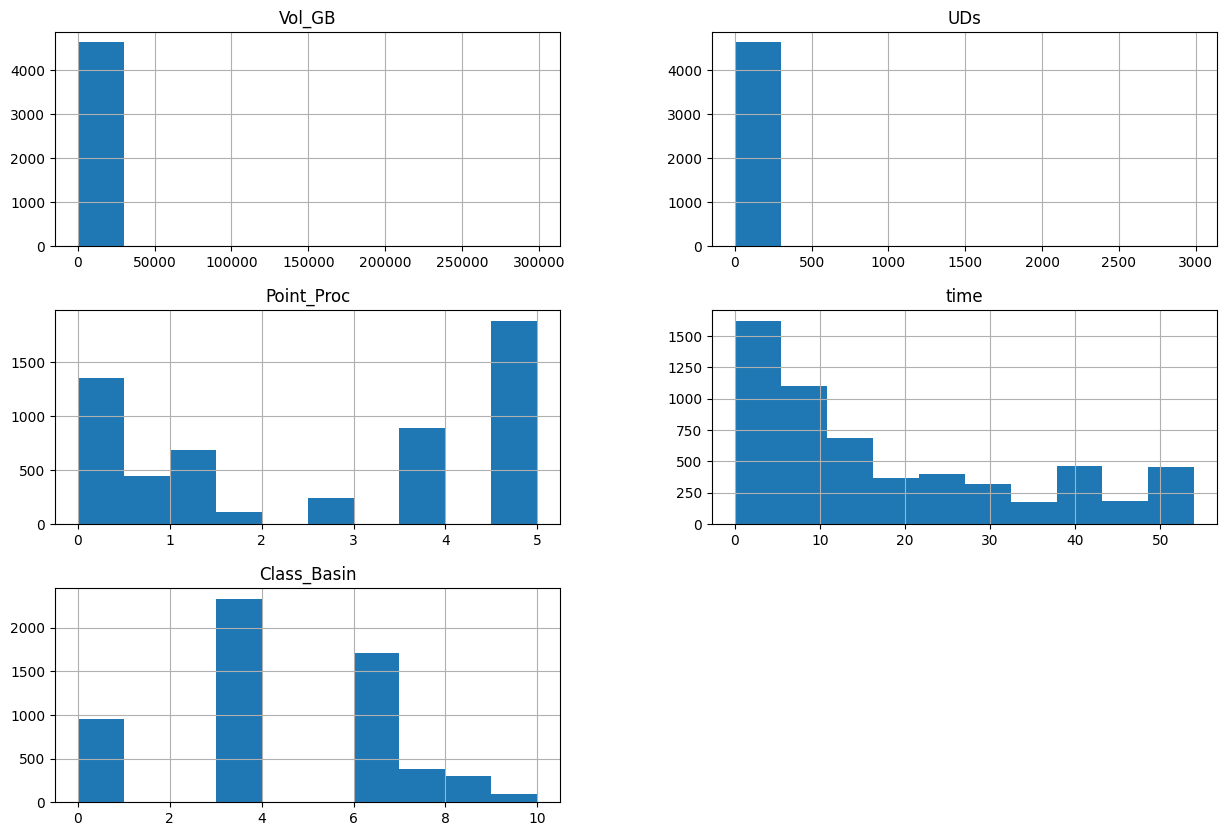

In [11]:
# Histograma
dataset.hist(figsize = (15,10))
plt.show()